In [94]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import ast
import seaborn as sns
from datetime import datetime

In [95]:
df = pd.read_csv(r"D:\KWF\analysis\Datasets\bioacoustics_dataset.csv")
for col in ['species', 'confidence', 'Sim Type']:
    df[col] =df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x,str) and x.startswith('[') else x)

In [96]:
df.drop(columns=['Duration (sec)','Sample Rate (Hz)','Channels','Bit Depth','File Size (KB)','Battery Voltage','Gain','Spectral Centroid','Zero Crossing Rate','start','Sim Relative Time','end','Sunrise','Sunset'], inplace=True)

In [97]:
df.Timestamp= df.Timestamp.apply(lambda dt: datetime.strptime(dt,"%Y%m%d_%H%M%S"))
# Setting the timestamp values

In [98]:
df =df.explode(['species','confidence'], ignore_index=True)

In [99]:
df = df[df['species'].apply(lambda x: isinstance(x, str) and x.strip() != '')]

In [100]:
df_selected_moth= df[df['Recorder'] == 'Audio_Moth_1'].copy()

In [101]:
df_selected_moth['species'].value_counts()

species
Ciccaba nigrolineata_Black-and-white Owl           26521
Lophostrix cristata_Crested Owl                    14621
Ciccaba virgata_Mottled Owl                         4862
Thamnophilus bridgesi_Black-hooded Antshrike        2491
Microrhopias quixensis_Dot-winged Antwren           2199
                                                   ...  
Icterus chrysater_Yellow-backed Oriole                 1
Todirostrum cinereum_Common Tody-Flycatcher            1
Tigrisoma mexicanum_Bare-throated Tiger-Heron          1
Tachybaptus dominicus_Least Grebe                      1
Pheugopedius fasciatoventris_Black-bellied Wren        1
Name: count, Length: 156, dtype: int64

In [102]:
df_selected_moth['Sim Type'].value_counts()

Sim Type
[]                                    60663
[Human Presence on Trail]                92
[Human Presence on Trail, Vehicle]       59
[Vehicle]                                 1
Name: count, dtype: int64

In [103]:
def _parse_listish(x):
   
    if isinstance(x, str) and x.strip().startswith('['):
        try:
            return ast.literal_eval(x)
        except Exception:
            return x
    return x

def _to_key(x):
    x = _parse_listish(x)
    if x is None or (isinstance(x, float) and pd.isna(x)):
        return frozenset()                     
    if isinstance(x, list):
        return frozenset(x)                   
    if isinstance(x, str):
        return frozenset([x])
    return frozenset([str(x)])

SIM_MAP = {
    frozenset(): 'no_simulation',

    frozenset(['Human Presence on Trail']): 'human',
    frozenset(['Vehicle']): 'vehicle',
    frozenset(['Gunshot']): 'gunshot',
    frozenset(['Human Presence off Trail']): 'human_off',
    frozenset(['Chainsaw']): 'chainsaw',


    frozenset(['Human Presence on Trail','Vehicle']): 'human_vehicle',
    frozenset(['Human Presence on Trail','Chainsaw']): 'human_chainsaw',
    frozenset(['Human Presence on Trail','Gunshot']): 'human_gunshot',

    frozenset(['Human Presence off Trail','Vehicle']): 'human_off_vehicle',
    frozenset(['Human Presence off Trail','Chainsaw']): 'human_off_chainsaw',
    frozenset(['Human Presence off Trail','Gunshot']): 'human_off_gunshot',

    frozenset(['Chainsaw','Gunshot']): 'chainsaw_gunshot',
    frozenset(['Gunshot','Vehicle']): 'gunshot_vehicle',
    frozenset(['Chainsaw','Vehicle']): 'chainsaw_vehicle',
    
    frozenset(['Human Presence on Trail','Vehicle','Chainsaw']): 'human_vehicle_chainsaw',
    frozenset(['Human Presence on Trail','Chainsaw','Gunshot']): 'human_chainsaw_gunshot',
    frozenset(['Human Presence on Trail','Gunshot','Vehicle']): 'human_gunshot_vehicle',  
}

def tag_sim_type(cell):
    return SIM_MAP.get(_to_key(cell), 'unmapped')

df_selected_moth['sim_tag'] = df_selected_moth['Sim Type'].apply(tag_sim_type)
print(df_selected_moth['sim_tag'].value_counts(dropna=False))


sim_tag
no_simulation    60663
human               92
human_vehicle       59
vehicle              1
Name: count, dtype: int64


In [104]:
species_counts = df_selected_moth['species'].dropna().value_counts()

common_species = species_counts[species_counts > 100].index

df_common_species = df_selected_moth[df_selected_moth['species'].isin(common_species)].copy()

print(f"{len(common_species)} species detected more than 100 times.")

27 species detected more than 100 times.


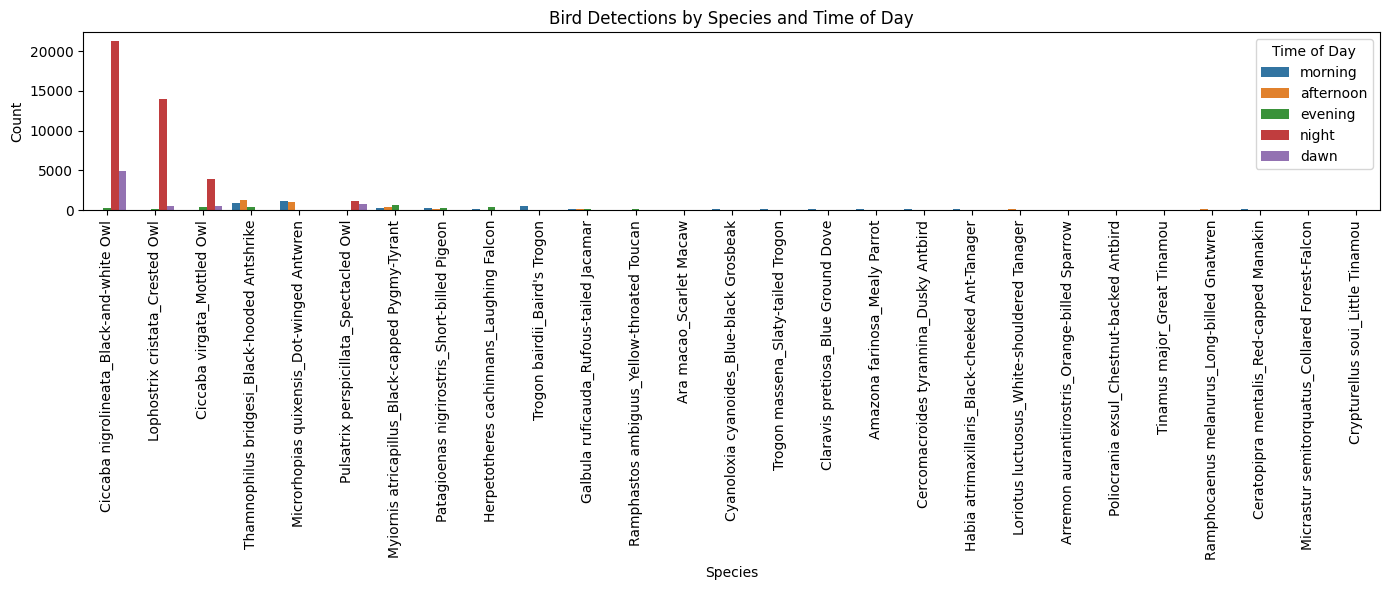

In [105]:
df_common_species = df_common_species.dropna(subset=['Time Of Day'])

plt.figure(figsize=(14, 6))
sns.countplot(data=df_common_species, x='species', hue='Time Of Day', order=common_species)
plt.xticks(rotation=90)
plt.title('Bird Detections by Species and Time of Day')
plt.xlabel('Species')
plt.ylabel('Count')
plt.legend(title='Time of Day')
plt.tight_layout()
plt.show()

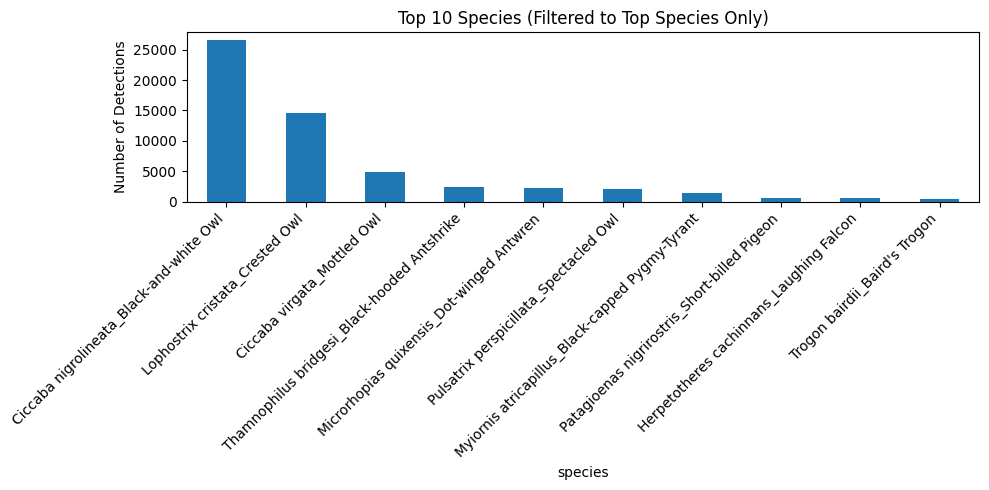

In [106]:
top10_species = df_common_species['species'].value_counts().head(10)

plt.figure(figsize=(10, 5))
top10_species.plot(kind='bar')
plt.title('Top 10 Species (Filtered to Top Species Only)')
plt.ylabel('Number of Detections')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [107]:
df_common_species['Timestamp'] = pd.to_datetime(df_common_species['Timestamp'])

date
2025-03-17     8982
2025-03-18    11812
2025-03-19    15245
2025-03-20    16908
2025-03-21     5918
dtype: int64


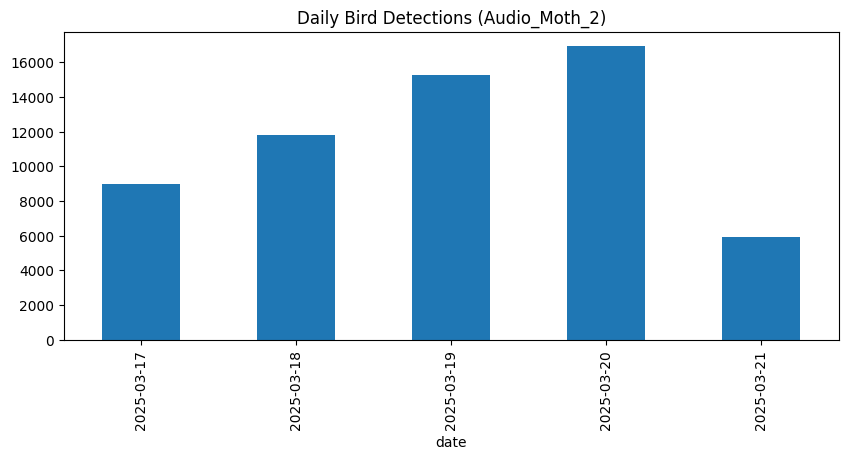

In [108]:
df_common_species['date'] = df_common_species['Timestamp'].dt.date
daily_counts = df_common_species.groupby('date').size()

daily_counts.plot(kind='bar', figsize=(10,4), title='Daily Bird Detections (Audio_Moth_2)')

print(daily_counts)

<Figure size 1200x600 with 0 Axes>

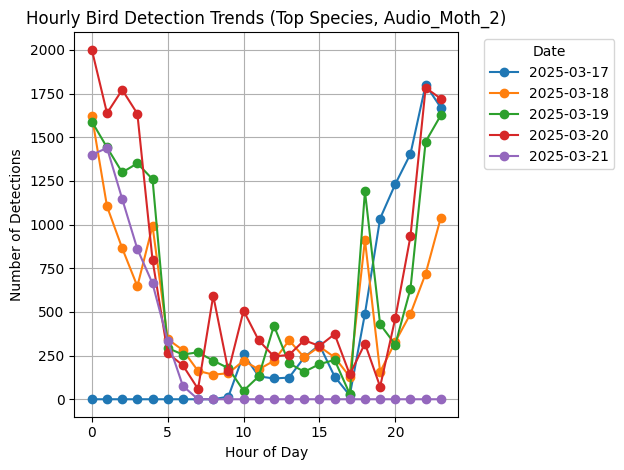

In [109]:
df_common_species['hour'] = df_common_species['Timestamp'].dt.hour

hourly_trends = df_common_species.groupby(['hour', 'date']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
hourly_trends.plot(marker='o')
plt.title('Hourly Bird Detection Trends (Top Species, Audio_Moth_2)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Detections')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

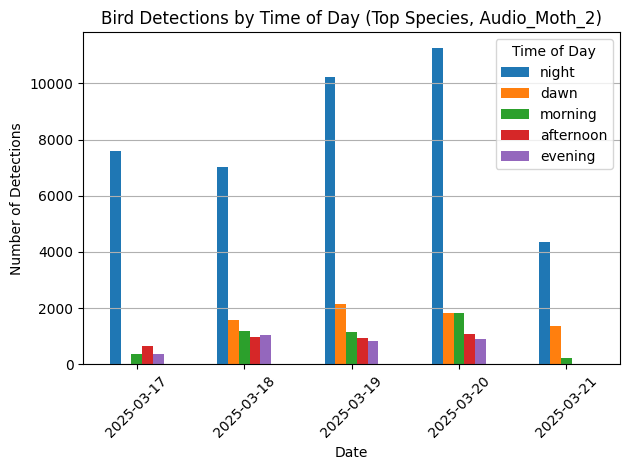

In [110]:
tod_daily_counts = df_common_species.groupby(['date', 'Time Of Day']).size().unstack().fillna(0)

ordered_tod = ['night', 'dawn', 'morning', 'afternoon', 'evening']
tod_daily_counts = tod_daily_counts.reindex(columns=ordered_tod, fill_value=0)

plt.figure(figsize=(10, 6))
tod_daily_counts.plot(kind='bar', stacked=False)
plt.title('Bird Detections by Time of Day (Top Species, Audio_Moth_2)')
plt.xlabel('Date')
plt.ylabel('Number of Detections')
plt.xticks(rotation=45)
plt.legend(title='Time of Day')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [111]:
grouped = df_common_species.groupby(['date', 'species']).size().reset_index(name='count')

top_species_each_day = (
    grouped.sort_values(['date', 'count'], ascending=[True, False])
           .groupby('date')
           .head(10)
)

pivot_df = top_species_each_day.pivot(index='species', columns='date', values='count').fillna(0).astype(int)

display(pivot_df)

date,2025-03-17,2025-03-18,2025-03-19,2025-03-20,2025-03-21
species,,,,,
Amazona farinosa_Mealy Parrot,0,0,0,0,22
Cercomacroides tyrannina_Dusky Antbird,0,0,0,0,34
Ciccaba nigrolineata_Black-and-white Owl,2944,4457,7624,7330,4166
Ciccaba virgata_Mottled Owl,964,1441,1442,794,221
Claravis pretiosa_Blue Ground Dove,183,0,0,0,0
Cyanoloxia cyanoides_Blue-black Grosbeak,0,0,99,0,0
Galbula ruficauda_Rufous-tailed Jacamar,0,142,0,188,0
Herpetotheres cachinnans_Laughing Falcon,0,197,182,199,0
Lophostrix cristata_Crested Owl,3584,2195,3034,4916,892


In [112]:
top_species_per_day = []


for day in df_common_species['date'].unique():
    daily_df = df_common_species[df_common_species['date'] == day]

    for species, count in top10_species.items():
        top_species_per_day.append({
            'date': day,
            'species': species,
            'count': count
        })
        
        
top_species_df = pd.DataFrame(top_species_per_day)  
     
display(top_species_df)

,date,species,count
0,2025-03-17,Ciccaba nigrolineata_Black-and-white Owl,26521
1,2025-03-17,Lophostrix cristata_Crested Owl,14621
2,2025-03-17,Ciccaba virgata_Mottled Owl,4862
3,2025-03-17,Thamnophilus bridgesi_Black-hooded Antshrike,2491
4,2025-03-17,Microrhopias quixensis_Dot-winged Antwren,2199
5,2025-03-17,Pulsatrix perspicillata_Spectacled Owl,2058
6,2025-03-17,Myiornis atricapillus_Black-capped Pygmy-Tyrant,1405
7,2025-03-17,Patagioenas nigrirostris_Short-billed Pigeon,680
8,2025-03-17,Herpetotheres cachinnans_Laughing Falcon,595
9,2025-03-17,Trogon bairdii_Baird's Trogon,511


In [ ]:
species_consistency = top_species_df['species'].value_counts()

consistent_top_species = species_consistency[species_consistency == 5]


print("Top species consistently in top 10 across all 5 days:")
print(consistent_top_species)

Top species consistently in top 10 across all 5 days:
species
Ciccaba nigrolineata_Black-and-white Owl           5
Lophostrix cristata_Crested Owl                    5
Ciccaba virgata_Mottled Owl                        5
Thamnophilus bridgesi_Black-hooded Antshrike       5
Microrhopias quixensis_Dot-winged Antwren          5
Pulsatrix perspicillata_Spectacled Owl             5
Myiornis atricapillus_Black-capped Pygmy-Tyrant    5
Patagioenas nigrirostris_Short-billed Pigeon       5
Herpetotheres cachinnans_Laughing Falcon           5
Trogon bairdii_Baird's Trogon                      5
Name: count, dtype: int64


In [114]:
single_day_species = species_consistency[species_consistency == 1].index

dominant_one_day_species = top_species_df[top_species_df['species'].isin(single_day_species)]

dominant_one_day_species_grouped = (
    dominant_one_day_species
    .groupby('species')['count']
    .sum()
    .reset_index()
    .sort_values(by='count', ascending=False)
    .reset_index(drop=True)
)

display(dominant_one_day_species_grouped)


,species,count


In [ ]:
species_sim_contrib = (
    df_common_species
    .groupby(['species', 'sim_tag'])
    .size()
    .reset_index(name='count')
) # this is used to groups rows by species and sim_tag

species_totals = species_sim_contrib.groupby('species')['count'].transform('sum')
species_sim_contrib['percentage'] = (species_sim_contrib['count'] / species_totals * 100).round(2)

# tidy pivots
species_sim_pct_pivot = (
    species_sim_contrib
    .pivot(index='species', columns='sim_tag', values='percentage')
    .fillna(0)
    .sort_index()
)

species_sim_cnt_pivot = (
    species_sim_contrib
    .pivot(index='species', columns='sim_tag', values='count')
    .fillna(0)
    .astype(int)
    .sort_index()
)

desired_order = [
    'no_simulation',
    'human', 'human_off', 'vehicle', 'chainsaw', 'gunshot',
    'human_vehicle', 'human_chainsaw', 'human_gunshot',
    'human_off_vehicle', 'human_off_chainsaw', 'human_off_gunshot',
    'chainsaw_gunshot', 'gunshot_vehicle', 'chainsaw_vehicle',
    'human_vehicle_chainsaw', 'human_chainsaw_gunshot', 'human_gunshot_vehicle'
]

cols_present = [c for c in desired_order if c in species_sim_pct_pivot.columns]
species_sim_pct_pivot = species_sim_pct_pivot.reindex(columns=cols_present)
species_sim_cnt_pivot = species_sim_cnt_pivot.reindex(columns=cols_present)

pd.set_option('display.max_columns', None)  
pd.set_option('display.width', 200)       
pd.set_option('display.expand_frame_repr', False)  

# I did these above steps to make pd display all the columns in one table and not to make multiple tables, I dont know the reason why it displayed multiple tables

print("PERCENTAGES (% of detections for each species across sim types):")
print(species_sim_pct_pivot)


PERCENTAGES (% of detections for each species across sim types):
sim_tag                                          no_simulation  human  human_vehicle
species                                                                             
Amazona farinosa_Mealy Parrot                           100.00   0.00           0.00
Ara macao_Scarlet Macaw                                 100.00   0.00           0.00
Arremon aurantiirostris_Orange-billed Sparrow           100.00   0.00           0.00
Ceratopipra mentalis_Red-capped Manakin                 100.00   0.00           0.00
Cercomacroides tyrannina_Dusky Antbird                  100.00   0.00           0.00
Ciccaba nigrolineata_Black-and-white Owl                100.00   0.00           0.00
Ciccaba virgata_Mottled Owl                             100.00   0.00           0.00
Claravis pretiosa_Blue Ground Dove                      100.00   0.00           0.00
Crypturellus soui_Little Tinamou                        100.00   0.00           0.00


The above code for ex means that: Out of the total deetctions of Patagioenas nigrirostris_Short-billed Pigeon, 3.09 perecent detections happen during human events.

In [116]:
print("\nCOUNTS (raw detections for each species across sim types):")
print(species_sim_cnt_pivot)


COUNTS (raw detections for each species across sim types):
sim_tag                                          no_simulation  human  human_vehicle
species                                                                             
Amazona farinosa_Mealy Parrot                              181      0              0
Ara macao_Scarlet Macaw                                    210      0              0
Arremon aurantiirostris_Orange-billed Sparrow              137      0              0
Ceratopipra mentalis_Red-capped Manakin                    113      0              0
Cercomacroides tyrannina_Dusky Antbird                     180      0              0
Ciccaba nigrolineata_Black-and-white Owl                 26521      0              0
Ciccaba virgata_Mottled Owl                               4862      0              0
Claravis pretiosa_Blue Ground Dove                         183      0              0
Crypturellus soui_Little Tinamou                           107      0              0
Cyano

In [117]:
total_tod = df_common_species['Time Of Day'].value_counts().to_dict()

tod_sim_counts = (
    df_common_species
    .groupby(['Time Of Day', 'sim_tag'])
    .size()
    .reset_index(name='count')
)

tod_sim_counts['total_tod'] = tod_sim_counts['Time Of Day'].map(total_tod)
tod_sim_counts['detection_rate(%)'] = (tod_sim_counts['count'] / tod_sim_counts['total_tod'] * 100).round(2)

print(tod_sim_counts)

  Time Of Day        sim_tag  count  total_tod  detection_rate(%)
0   afternoon  no_simulation   3628       3628             100.00
1        dawn  no_simulation   6908       6908             100.00
2     evening          human      4       3135               0.13
3     evening  no_simulation   3131       3135              99.87
4     morning          human     80       4737               1.69
5     morning  human_vehicle     58       4737               1.22
6     morning  no_simulation   4599       4737              97.09
7       night  no_simulation  40457      40457             100.00


The above analysis can be explained as: During Evening there were a total of 3155 detections and out of that 4 were only human and the rest were no_sim.

In [ ]:
species_sim_summary = (
    df_selected_moth
    .groupby(['sim_tag', 'species'])
    .size()
    .reset_index(name='count')
    .sort_values(by='count', ascending=False)
)

species_sim_pivot = species_sim_summary.pivot(index='species', columns='sim_tag', values='count').fillna(0)

species_sim_percent = species_sim_pivot.div(species_sim_pivot.sum(axis=0), axis=1) * 100

species_sim_percent['total'] = species_sim_percent.sum(axis=1)

species_sim_percent = species_sim_percent.sort_values('human', ascending=False)
                                                      
species_sim_percent.drop(columns='total').head(15)

sim_tag,human,human_vehicle,no_simulation,vehicle
species,,,,
Thamnophilus bridgesi_Black-hooded Antshrike,46.739130,8.474576,4.027166,0.0
Patagioenas nigrirostris_Short-billed Pigeon,22.826087,88.135593,1.000610,0.0
Cyanoloxia cyanoides_Blue-black Grosbeak,14.130435,1.694915,0.298370,0.0
Myiornis atricapillus_Black-capped Pygmy-Tyrant,6.521739,0.000000,2.306183,0.0
Thamnophilus doliatus_Barred Antshrike,6.521739,0.000000,0.151658,0.0
Galbula ruficauda_Rufous-tailed Jacamar,1.086957,0.000000,0.712131,0.0
Tolmomyias sulphurescens_Yellow-olive Flycatcher,1.086957,0.000000,0.032969,0.0
Hylophylax naevioides_Spotted Antbird,1.086957,1.694915,0.051102,0.0
Amazilia tzacatl_Rufous-tailed Hummingbird,0.000000,0.000000,0.006594,0.0


The above table illustrates that out of all the human events, 46% events have Thamnophilus bridgesi_Black-hooded Antshrike's detections.

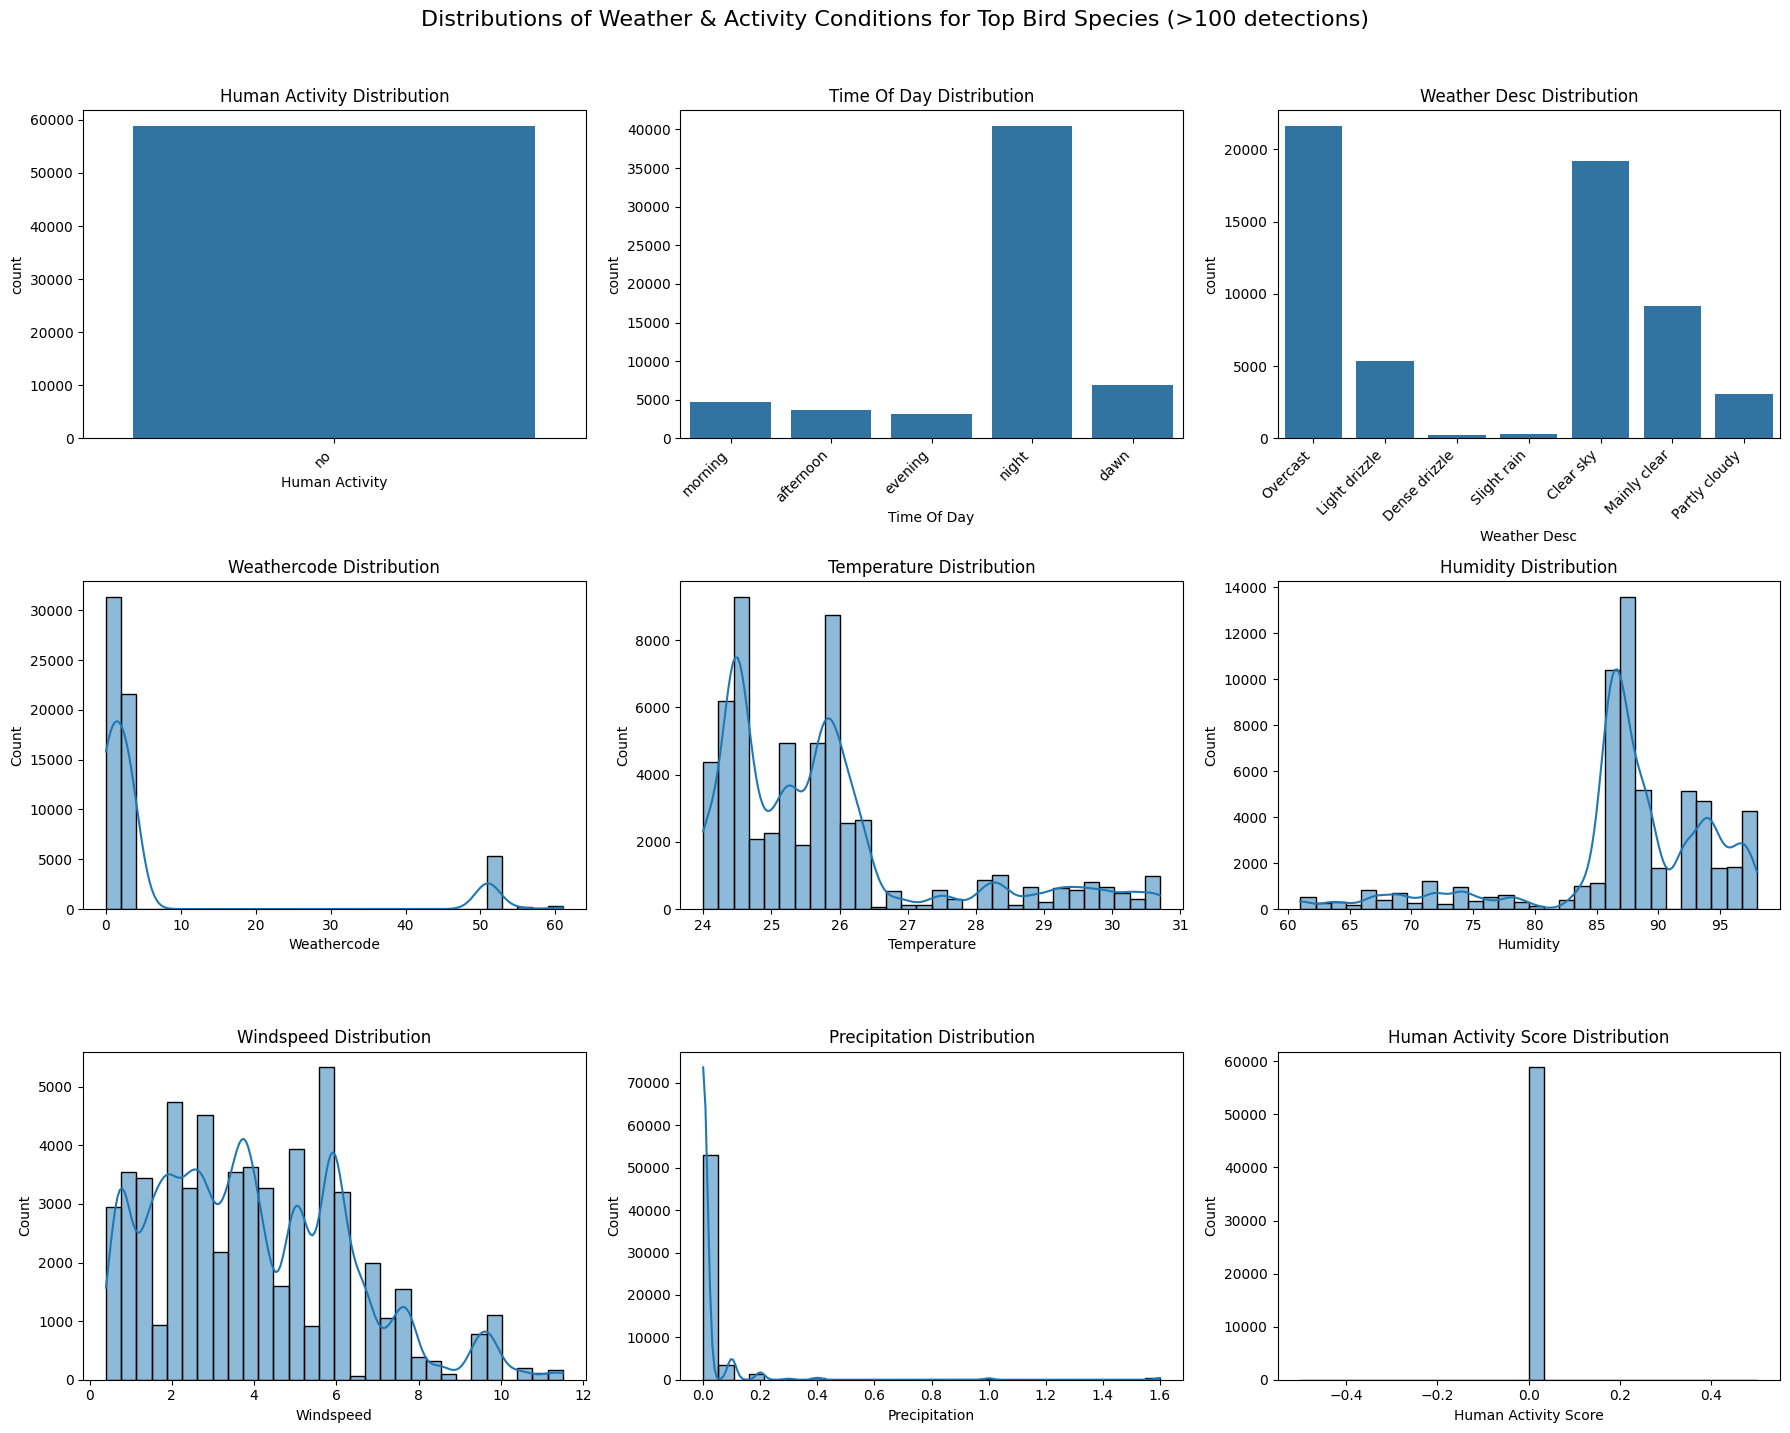

In [119]:
species_counts = df_common_species['species'].value_counts()
top_species = species_counts[species_counts > 100].index
df_top_species = df_common_species[df_common_species['species'].isin(top_species)]

features = {
    'Human Activity': 'Human Activity Distribution',
    'Time Of Day': 'Time Of Day Distribution',
    'Weather Desc': 'Weather Desc Distribution',
    'Weathercode': 'Weathercode Distribution',
    'Temperature': 'Temperature Distribution',
    'Humidity': 'Humidity Distribution',
    'Windspeed': 'Windspeed Distribution',
    'Precipitation': 'Precipitation Distribution',
    'Human Activity Score': 'Human Activity Score Distribution'
}

plt.figure(figsize=(18, 14))
for idx, (col, title) in enumerate(features.items(), 1):
    plt.subplot(3, 3, idx)
    if df_top_species[col].dtype == 'object':
        sns.countplot(data=df_top_species, x=col)
        plt.xticks(rotation=45, ha='right')
    else:
        sns.histplot(data=df_top_species, x=col, bins=30, kde=True)
    plt.title(title)
    plt.tight_layout()

plt.suptitle("Distributions of Weather & Activity Conditions for Top Bird Species (>100 detections)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()
